# Sentimental Analysis on metadata of 'Clothing, Shoes and Jewelry' category from Amazon, including 2.5 million reviews spanning May 1996 - July 2014.

This dataset includes the reviews (ratings, text, helpfulness votes) and product metadata (descriptions, category information, price, brand, and image features).

In [71]:
import glob
import json
import csv
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
import string
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
import warnings
warnings.filterwarnings("ignore")

The input dataset for Sentiment Analysis.

In [72]:
file=glob.glob('E:\CapstoneProject\Review.json')

Cleaning the data file and putting the data as pandas DataFrame.

In [74]:
data_review=[]
with open(file[0]) as data:
    data=data.read()
    for i in data.split('\n'):
        data_review.append(i)
        
dataframe_review=[]
for x in data_review:
    try:
        jdata=json.loads(x)
        dataframe_review.append((jdata['reviewerID'],jdata['asin'],jdata['reviewerName'],jdata['helpful'][0],jdata['helpful'][1],jdata['reviewText'],jdata['overall'],jdata['summary'],jdata['unixReviewTime'],jdata['reviewTime'])) 
    except:
        pass        
    
dataset=pd.DataFrame(dataframe_review,columns=['Reviewer_ID','Asin','Reviewer_Name','helpful_UpVote','Total_Votes','Review_Text','Rating','Summary','Unix_Review_Time','Review_Time'])

Calculating the sentiments using Naive Bayes Analyzer.

In [75]:
def NaiveBayes(text):
    data_blob = TextBlob(text, analyzer=NaiveBayesAnalyzer())
    SentimentScore=blob.sentiment.classification
    return SentimentScore

Calculating the sentiments using Vader Sentiment Analyzer.

In [84]:
def sentimental(text):
    analyzer = SentimentIntensityAnalyzer()
    a = analyzer.polarity_scores(text)
    result=a['compound']
    return result

def sentimental_result(text):
    analyzer = SentimentIntensityAnalyzer()
    a = analyzer.polarity_scores(text)
    result=a['compound']
    if result >= 0.5:
        return 'pos'
    elif (result > -0.5) and (result < 0.5):
        return 'neu'
    elif result <= -0.5:
        return 'neg'

Calculating sentiment value for each review.

In [85]:
data_rows=dataset.head(100000)
data_rows['Sentiment_Score']=data_rows['Review_Text'].apply(lambda x: sentimental_result(x))

In [22]:
data_rows.to_csv(r'E:\CapstoneProject\sentimental.csv')

In [87]:
positive = data_rows.loc[data_rows['Sentiment_Score'] == 'pos']
negative = data_rows.loc[data_rows['Sentiment_Score'] == 'neg']

The stemming function is used for stemming the different form of words for the Word_Corpus function.

In [88]:
def stemming(tokens):
    a=PorterStemmer()
    words=[]
    for x in tokens:
        words.append(a.stem(x))
    return words

In [89]:
def Word_Corpus(df):
    words_corpus = ''
    for val in df["Summary"]:
        text = val.lower()
        tokens = nltk.word_tokenize(text)
        tokens = [word for word in tokens if word not in string.punctuation]
        tokens = [word for word in tokens if word not in stopwords.words('english')]
        tokens = stemming(tokens)
        for words in tokens:
            words_corpus = words_corpus + words + ' '
    return words_corpus

The plot_word_cloud() is used to plot the word cloud.

In [90]:
def plot_word_cloud(c):
    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(word)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    plt.savefig('words.png', facecolor='k', bbox_inches='tight')

In [92]:
positive_wordcloud = WordCloud(width=900, height=500).generate(Word_Corpus(positive))
negative_wordcloud = WordCloud(width=900, height=500).generate(Word_Corpus(negative))

Creating a word cloud of the positive reviews.

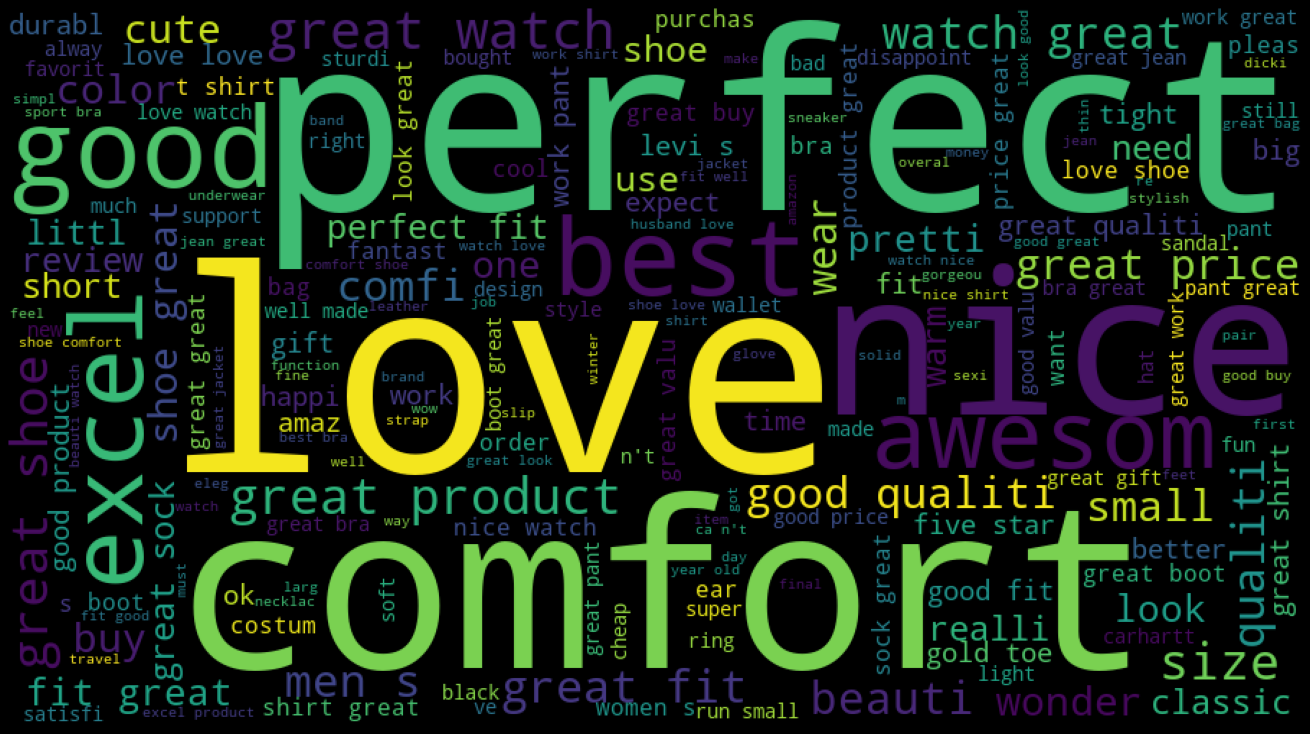

<Figure size 432x288 with 0 Axes>

In [93]:
plot_Cloud(positive_wordcloud)

Creating a word cloud of the negative reviews.

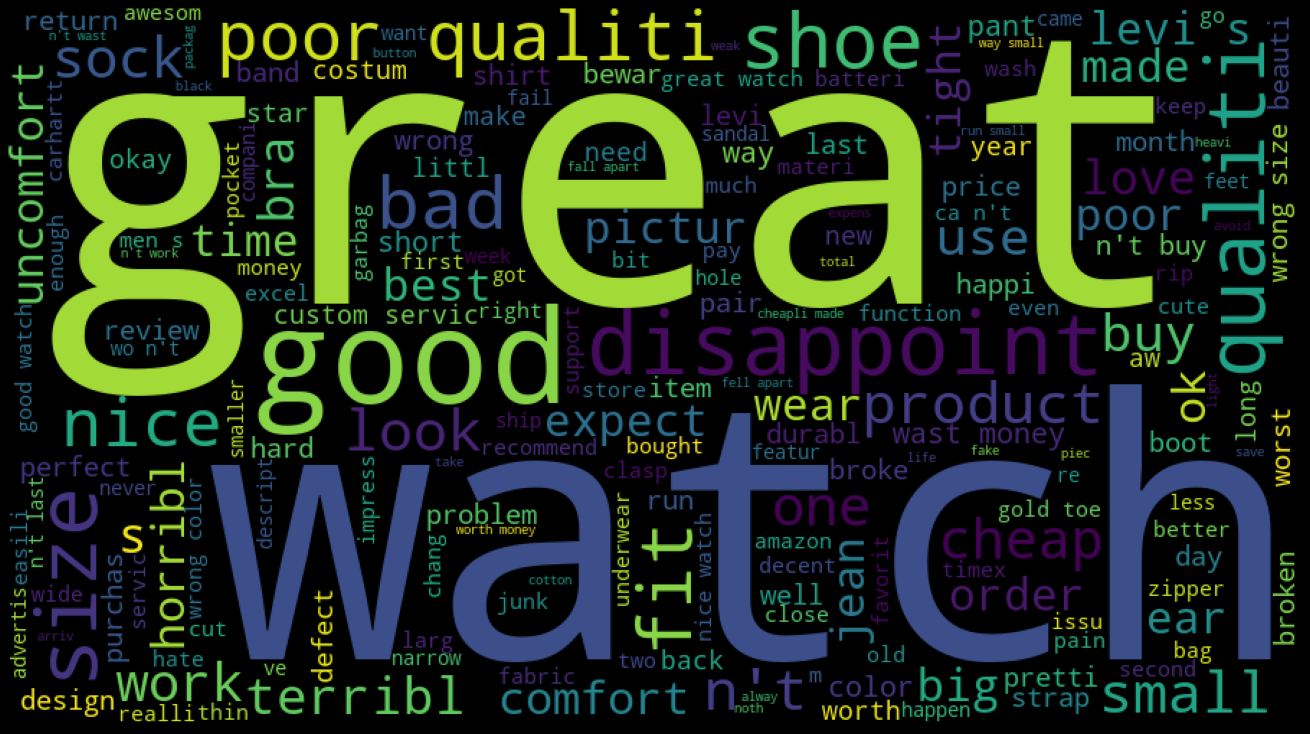

<Figure size 432x288 with 0 Axes>

In [94]:
plot_Cloud(negative_wordcloud)

# THE SENTIMENT DISTRIBUTION ACROSS EACH PRODUCT.

In [95]:
data_file=glob.glob('E:\CapstoneProject\Product.json')

Cleaning the data file and putting the data as pandas DataFrame.

In [96]:
product=[]
with open(data_file[0]) as data_file:
    data=data_file.read()
    for i in data.split('\n'):
        product.append(i)
               
productDataframe=[]
for x in product:
    try:
        y=x.replace("'",'"')
        jdata=json.loads(y)
        productDataframe.append((jdata['asin'],jdata['title'])) 
    except:
        pass
    
Product_dataset=pd.DataFrame(productDataframe,columns=['Asin','Title'])

In [99]:
Sentimemt_Score_Product=data_rows[['Asin','Sentiment_Score']]

Using Groupby on 'Asin' and 'Sentiment_Score' to calculate the count of all the products with positive, negative and neutral sentiment score.

In [100]:
Sentimemt_Score_Product=Sentimemt_Score_Product.groupby(['Asin','Sentiment_Score']).size().reset_index()

Taking the Required columns only and Sorting the rows in the ascending order of 'Asin'.

In [101]:
Sentimemt_Score_Product['Count']=Sentimemt_Score_Product[0]
Sentimemt_Score_Product=Sentimemt_Score_Product[['Asin','Sentiment_Score','Count']]
a1=Sentimemt_Score_Product.sort_values(['Asin','Count'],ascending=True).groupby(['Asin']).head()

The products Asin and Title is assigned to a2 which is a copy of DataFrame 'Product_datset'.

In [102]:
a2=Product_dataset

Merging two Dataframes 'a1' and 'a2' on common Column 'Asin' to map product 'Title' to respective product 'Asin' using inner type.

In [103]:
result=pd.merge(a2, a1, on='Asin', how='inner')

In [45]:
result.to_csv('E:\CapstoneProject\Sentiment_Distribution_Across_Product.csv')

# THE PERCENTAGE DISTRIBUTION OF POSITIVE, NEGATIVE AND  NEUTRAL IN TERMS OF SENTIMENTS.

Getting the summation of count column to get the total count of reviews.

In [104]:
Percentage=result.groupby('Sentiment_Score')['Count'].sum().reset_index()

Calculating the percentage and storing the value into a new column 'Percentage'.

In [105]:
Percentage['Percentage']=(Percentage.Count/Percentage.Count.sum())*100

In [106]:
Percentage.to_csv('E:\CapstoneProject\Sentiment_Percentage.csv')

# THE SENTIMENT DISTRIBUTION ACROSS THE YEAR

Converting the data type of 'Review_Time' column in the Dataframe 'data_rows' to datetime format.

In [112]:
data_rows['Review_Time']= pd.to_datetime(data_rows['Review_Time'])

Creating an Addtional column as 'Month' in Datatframe 'data_rows' for Month by taking the month part of 'Review_Time' column.

In [113]:
data_rows['Month']=data_rows['Review_Time'].dt.month

Creating an Addtional column as 'Year' in Datatframe 'data_rows' for Year by taking the year part of 'Review_Time' column.

In [114]:
data_rows['Year']=data_rows['Review_Time'].dt.year

Grouping on the basis of 'Year' and 'Sentiment_Score' to get the respective count.

In [115]:
Sentiment_Year=data_rows.groupby(['Year','Sentiment_Score'])['Asin'].count().reset_index()

In [116]:
Sentiment_Year=Sentiment_Year.rename(columns={'Asin': 'Count'})

Segregating the rows based on their sentiments by year.

In [117]:
Positive_Year = Sentiment_Year[Sentiment_Year.Sentiment_Score == 'pos']
Negative_Year = Sentiment_Year[Sentiment_Year.Sentiment_Score == 'neg']
Neutral_Year = Sentiment_Year[Sentiment_Year.Sentiment_Score == 'neu']

Getting the total count including positive, negative and neutral to get the total count of reviews for each year.

In [118]:
Sentiment_Total_Year=Sentiment_Year.groupby('Year')['Count'].sum().reset_index()

In [119]:
Sentiment_Total_Year=Sentiment_Total_Year.rename(columns={'Count': 'Total_Count'})

Merging the dataframe with total count to individual sentiment count to get percentage.

In [120]:
result_Positive_Year=pd.merge(Positive_Year, Sentiment_Total_Year, on='Year', how='inner')
result_Negative_Year=pd.merge(Negative_Year, Sentiment_Total_Year, on='Year', how='inner')
result_Neutral_Year=pd.merge(Neutral_Year, Sentiment_Total_Year, on='Year', how='inner')

Calculating the percentage to getting to know the trend for sentiments.

In [121]:
result_Positive_Year['Percentage']=(result_Positive_Year['Count']/result_Positive_Year['Total_Count'])*100
result_Negative_Year['Percentage']=(result_Negative_Year['Count']/result_Negative_Year['Total_Count'])*100
result_Neutral_Year['Percentage']=(result_Neutral_Year['Count']/result_Neutral_Year['Total_Count'])*100

Bar-Chart to know the Trend for Percentage of Positive Review over the years based on Sentiments.

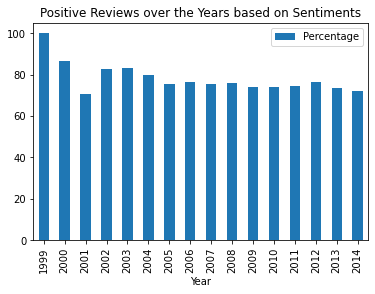

In [122]:
result_Positive_Year.plot(x="Year",y="Percentage",kind="bar",title="Positive Reviews over the Years based on Sentiments")
plt.show()

Bar-Chart to know the Trend for Percentage of Negative Review over the years based on Sentiments.

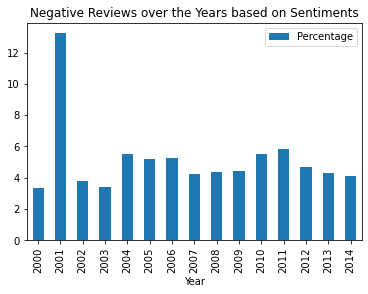

In [123]:
result_Negative_Year.plot(x="Year",y="Percentage",kind="bar",title="Negative Reviews over the Years based on Sentiments")
plt.show()

Bar-Chart to know the Trend for Percentage of Neutral Review over the years based on Sentiments.

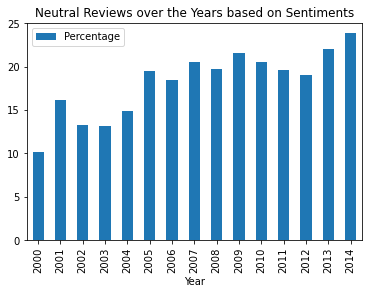

In [124]:
result_Neutral_Year.plot(x="Year",y="Percentage",kind="bar",title="Neutral Reviews over the Years based on Sentiments")
plt.show()